In [3]:
import numpy as np
import matplotlib.pylab as plb
def name2digits(name):
    """ takes a string NAME and converts it into a pseudo-random selection of 4
     digits from 0-9.
     
     Example:
     name2digits('Felipe Gerhard')
     returns: [0 4 5 7]
     """
    
    name = name.lower()
    
    if len(name)>25:
        name = name[0:25]
        
    primenumbers = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71,73,79,83,89,97]
    
    n = len(name)
    
    s = 0.0
    
    for i in range(n):
        s += primenumbers[i]*ord(name[i])*2.0**(i+1)

    import scipy.io.matlab
    Data = scipy.io.matlab.loadmat('hash.mat',struct_as_record=True)
    x = Data['x']
    t = np.mod(s,x.shape[0])

    return np.sort(x[t,:])

In [4]:
targetdigits = name2digits('Prisca Aeby') # assign the four digits that should be used
print(targetdigits) # output the digits that were selected

[0 1 5 6]


/Users/prisca/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [100]:
# load in data and labels    
data = np.array(np.loadtxt('data.txt'))
labels = np.loadtxt('labels.txt')

# this selects all data vectors that corresponds to one of the four digits
targ_labels = np.logical_or.reduce([labels==x for x in targetdigits])
data = data[targ_labels,:]
labels = labels[targ_labels]

In [103]:
def kohonen(size_k, sigma, eta, converged_err):
    """Example for using create_data, plot_data and som_step.
    """
    plb.close('all')
    
    dim = 28*28
    data_range = 255.0
    
    dy, dx = data.shape
    
    #set the size of the Kohonen map. In this case it will be 6 X 6
    #size_k = 6
    
    #set the width of the neighborhood via the width of the gaussian that
    #describes it
    #sigma = 4.0
    
    #initialise the centers randomly
    centers = np.random.rand(size_k**2, dim) * data_range
    
    #build a neighborhood matrix
    neighbor = np.arange(size_k**2).reshape((size_k, size_k))

    #set the learning rate
    #eta = 0.8 # HERE YOU HAVE TO SET YOUR OWN LEARNING RATE
    
    #set the maximal iteration count
    tmax = 100000 # this might or might not work; use your own convergence criterion
    
    #set the random order in which the datapoints should be presented
    i_random = np.arange(tmax) % dy
    np.random.shuffle(i_random)
    
    #error matrix for each point of the Kohonen map (36)
    errors = np.zeros((size_k, size_k))
    
    #points which have converged
    converged = np.zeros((size_k, size_k))
    
    for t, i in enumerate(i_random):
        # Reduce eta over time, not asked so we shall see if we keep it or not
        if eta > 0.2:
            eta = eta*0.999
        # Reduce size of neighborhood, comment for first questions.
        if sigma > 1:
            sigma = sigma*0.999
        oldCenters = np.copy(centers)
        a,b = som_step(centers, data[i,:],neighbor,eta,sigma)
        oldError = errors[a][b]
        newError = np.sum(np.abs(oldCenters - centers))
        errors[a][b] = newError
        
        # check if point have converged
        if(np.abs(oldError-newError) < converged_err):
            converged[a][b] = 1
            
            #all points have converged
            if(np.sum(converged) == (size_k**2)):
                print("It has converged after: "+str(t)+" steps, with eta = "+ str(eta))
                break
    
    # for visualization, you can use this:
    for i in range(size_k**2):
        plb.subplot(size_k,size_k,i+1)
        # find the data closest to the node and get its label
        ind = np.argmin(np.sum((centers[i, :] - data[:])**2,1))
        plb.title(labels[ind], fontsize=8)
        plb.imshow(np.reshape(centers[i,:], [28, 28]),interpolation='bilinear')
        plb.subplots_adjust(hspace=0.5)
        plb.axis('off')
        
    # leave the window open at the end of the loop
    plb.show()
    plb.draw()
   
    

def som_step(centers,data,neighbor,eta,sigma):
    """Performs one step of the sequential learning for a 
    self-organized map (SOM).
    
      centers = som_step(centers,data,neighbor,eta,sigma)
    
      Input and output arguments: 
       centers  (matrix) cluster centres. Have to be in format:
                         center X dimension
       data     (vector) the actually presented datapoint to be presented in
                         this timestep
       neighbor (matrix) the coordinates of the centers in the desired
                         neighborhood.
       eta      (scalar) a learning rate
       sigma    (scalar) the width of the gaussian neighborhood function.
                         Effectively describing the width of the neighborhood
    """
    
    size_k = int(np.sqrt(len(centers)))
    
    #find the best matching unit via the minimal distance to the datapoint
    b = np.argmin(np.sum((centers - np.resize(data, (size_k**2, data.size)))**2,1))
    
    # find coordinates of the winner
    a,b = np.nonzero(neighbor == b)
   
    # update all units
    for j in range(size_k**2):
        # find coordinates of this unit
        a1,b1 = np.nonzero(neighbor==j)
        # calculate the distance and discounting factor
        disc=gauss(np.sqrt((a-a1)**2+(b-b1)**2),[0, sigma])
        # update weights        
        centers[j,:] += disc * eta * (data - centers[j,:])
        
    return a[0], b[0]    
    
def gauss(x,p):
    """Return the gauss function N(x), with mean p[0] and std p[1].
    Normalized such that N(x=p[0]) = 1.
    """
    return np.exp((-(x - p[0])**2) / (2 * p[1]**2))

It has converged after: 6647 steps, with eta = 0.1999201956806832


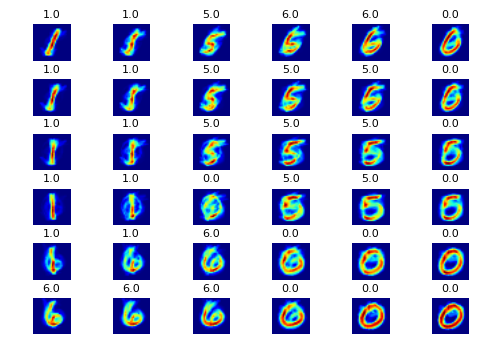

In [104]:
kohonen(6, 4.0, 0.8, 300)